<a href="https://colab.research.google.com/github/gabri035/LeOpzioni/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install pmdarima
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 25.5 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


Risultati Test ADF sulla serie originale:
ADF: -1.6959
p-value: 0.4332

Risultati Test ADF sulla serie differenziata:
ADF Statistic: -8.0001
p-value: 0.0000


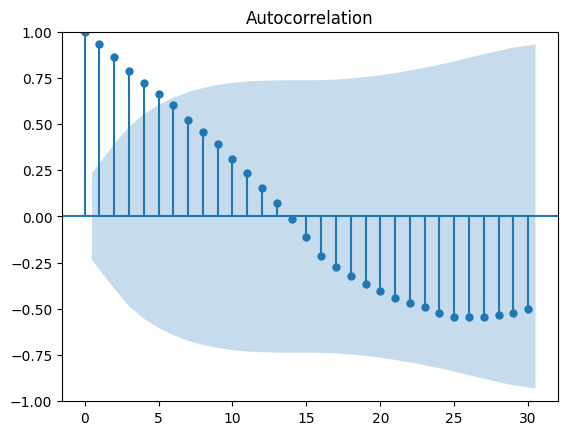

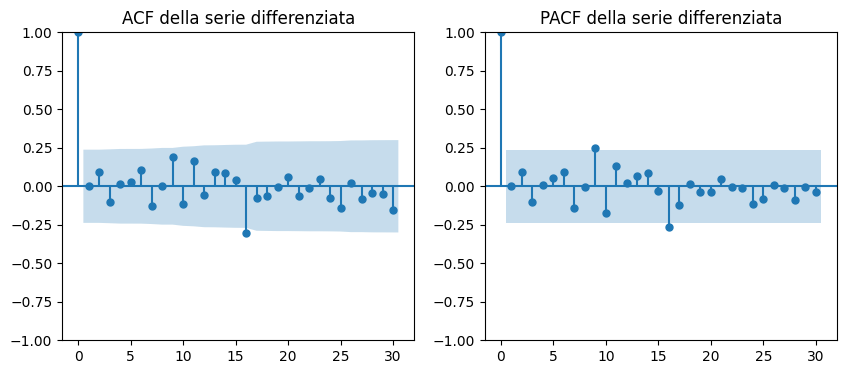

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                   69
Model:                ARIMA(16, 1, 0)   Log Likelihood                -169.183
Date:                Wed, 12 Feb 2025   AIC                            372.367
Time:                        20:14:28   BIC                            410.098
Sample:                             0   HQIC                           387.317
                                 - 69                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0806      0.147      0.549      0.583      -0.207       0.369
ar.L2          0.1312      0.154      0.850      0.396      -0.171       0.434
ar.L3         -0.1059      0.201     -0.528      0.5

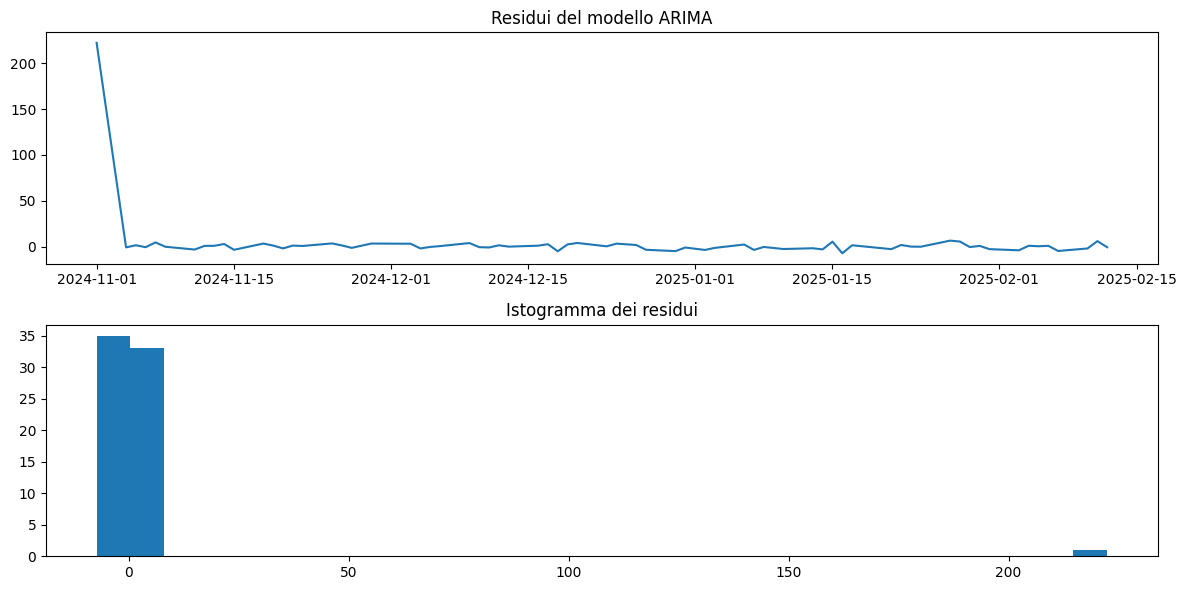

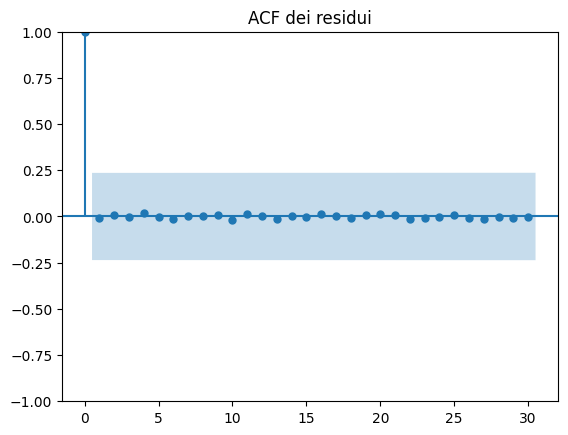

Risultati del Test Ljung-Box:
     lb_stat  lb_pvalue
10  0.091899        1.0


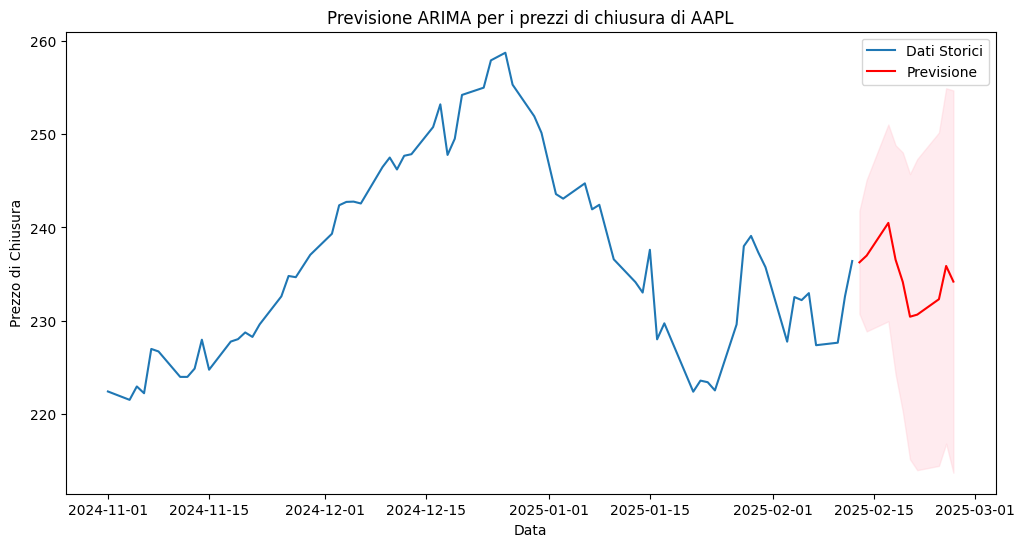

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings

warnings.filterwarnings("ignore")

start_date = '2024-11-1'
data = yf.download('AAPL', start=start_date, period="1d",)
close = data['Close'].dropna()
plot_acf(close, lags=30)

# -----------------------------------------------------
# Verifica di stazionarietà con il test di Dickey-Fuller
result = adfuller(close.dropna())
print('Risultati Test ADF sulla serie originale:')
print(f'ADF: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')

# ------------------------------------------------
# Differenziazione
close_diff = close.diff().dropna()
result_diff = adfuller(close_diff)
print('\nRisultati Test ADF sulla serie differenziata:')
print(f'ADF Statistic: {result_diff[0]:.4f}')
print(f'p-value: {result_diff[1]:.4f}')


# Plot di ACF e PACF per individuare possibili valori di p e q
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(close_diff, lags=30, ax=axes[0])
axes[0].set_title('ACF della serie differenziata')
plot_pacf(close_diff, lags=30, ax=axes[1])
axes[1].set_title('PACF della serie differenziata')
plt.show()



# Fit del modello ARIMA
order = (9, 1, 9)   # order = (p,d,q)
model = ARIMA(close, order=order)
model_fit = model.fit()

print(model_fit.summary())




residuals = model_fit.resid

# Plot dei residui e del loro istogramma
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residui del modello ARIMA')
plt.subplot(212)
plt.hist(residuals, bins=30)
plt.title('Istogramma dei residui')
plt.tight_layout()
plt.show()

# Plot dell'ACF dei residui
plot_acf(residuals, lags=30)
plt.title('ACF dei residui')
plt.show()

# Test Ljung-Box per verificare l'assenza di autocorrelazione nei residui
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Risultati del Test Ljung-Box:")
print(lb_test)

# ------------------------------------------------
# 6. Previsione con il modello ARIMA
# ------------------------------------------------
forecast_steps = 10  # Prevediamo i prossimi 30 giorni
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int()

# Creazione dell'indice temporale per le previsioni
forecast_index = pd.date_range(start=close.index[-1], periods=forecast_steps+1, freq='B')[1:]

# Plot della serie storica e della previsione
plt.figure(figsize=(12,6))
plt.plot(close, label='Dati Storici')
plt.plot(forecast_index, forecast_mean, label='Previsione', color='red')
plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('Previsione ARIMA per i prezzi di chiusura di AAPL')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura')
plt.legend()
plt.show()


In [ ]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph(format='png')

# Add nodes
dot.node('1', '1. Plottiamo i dati, individuiamo eventuali pattern', shape='rectangle', style='filled', fillcolor='#CCCCFF')
dot.node('2', '2. Se la serie è non stazionaria\nusiamo la differenziazione', shape='rectangle', style='filled', fillcolor='#CCCCFF')
dot.node('3', 'Costruiamo il nostro\nmodello manualmente', shape='ellipse', style='filled', fillcolor='#FFCCCC')
dot.node('4', 'Implementiamo un algoritmo\nautomatico', shape='ellipse', style='filled', fillcolor='#FFCCCC')
dot.node('5', 'Usiamo ARIMA() per trovare il modello\ncon i migliori parametri', shape='rectangle', style='filled', fillcolor='#CCCCFF')
dot.node('6', '3. If necessary, difference\nthe data until it appears stationary.\nUse unit-root tests if you are unsure.', shape='rectangle', style='filled', fillcolor='#CCCCFF')
dot.node('6', '4. Plottiamo ACF/PACF\ncerchiamo possibili valori per p e q', shape='rectangle', style='filled', fillcolor='#CCCCFF')
dot.node('7', '5. Usiamo AICc pe\nper trovare i parametri p e q', shape='rectangle', style='filled', fillcolor='#CCCCFF')
dot.node('8', '6. Analisi dei residui\n plot ACF', shape='rectangle', style='filled', fillcolor='#CCCCFF')
dot.node('9', '7. Calcoliamo le previsioni', shape='rectangle', style='filled', fillcolor='#CCCCFF')

# Add edges (connections)
dot.edge('1', '2')
dot.edge('2', '3')
dot.edge('2', '4')
dot.edge('4', '5')
dot.edge('3', '6')
dot.edge('6', '7')
dot.edge('7', '8')
dot.edge('8', '9')
dot.edge('5', '8')



# Render the flowchart
dot.render('arima_flowchart')

print("Flowchart created successfully as 'arima_flowchart.png'")


Flowchart created successfully as 'arima_flowchart.png'


[*********************100%***********************]  1 of 1 completed


Dimensione del dataset totale: 113
Dimensione del training set: 96
Dimensione del test set: 17

Risultati Test ADF sulla serie di training differenziata:
ADF Statistic: -9.7292
p-value: 0.0000


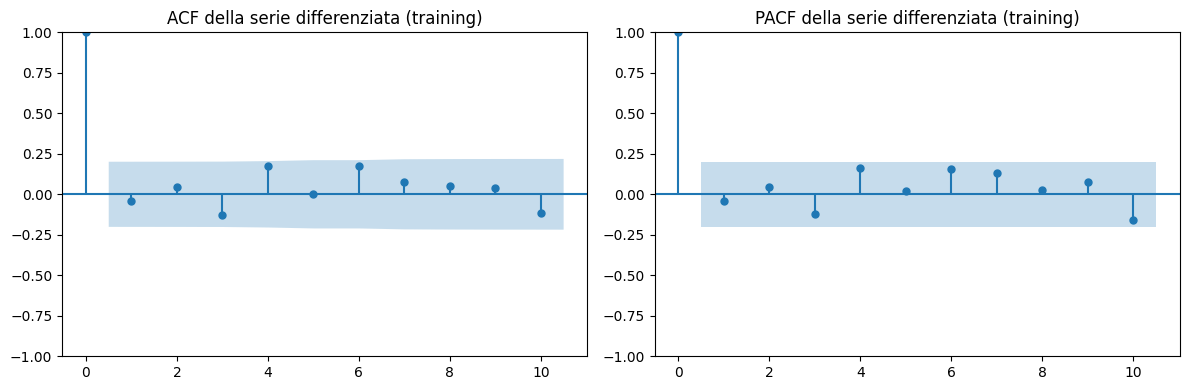


Sintesi del modello ARIMA adattato sui dati di training:
                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                   96
Model:                 ARIMA(9, 1, 9)   Log Likelihood                -227.437
Date:                Thu, 13 Feb 2025   AIC                            492.873
Time:                        19:11:34   BIC                            541.397
Sample:                             0   HQIC                           512.480
                                 - 96                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1891      0.626     -0.302      0.762      -1.415       1.037
ar.L2         -0.4978      0.405     -1.231      0.218      -1.291       

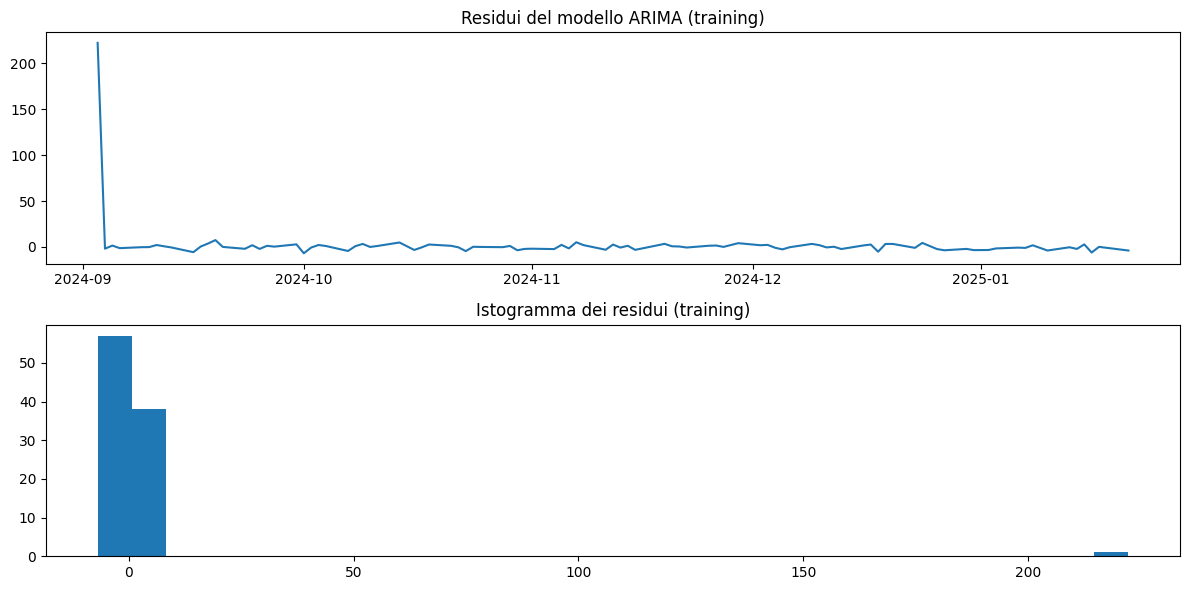

<Figure size 800x400 with 0 Axes>

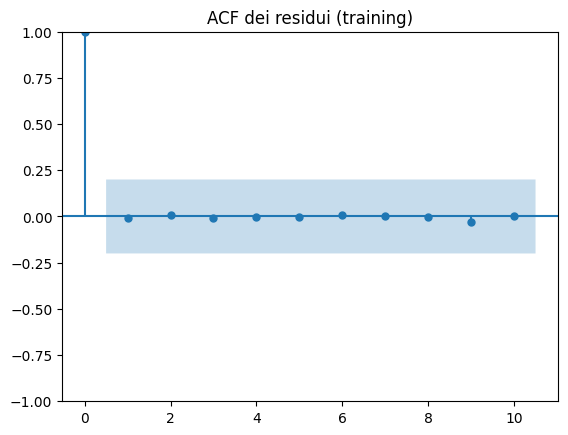

Risultati del Test Ljung-Box sui residui (training):
     lb_stat  lb_pvalue
10  0.110052        1.0


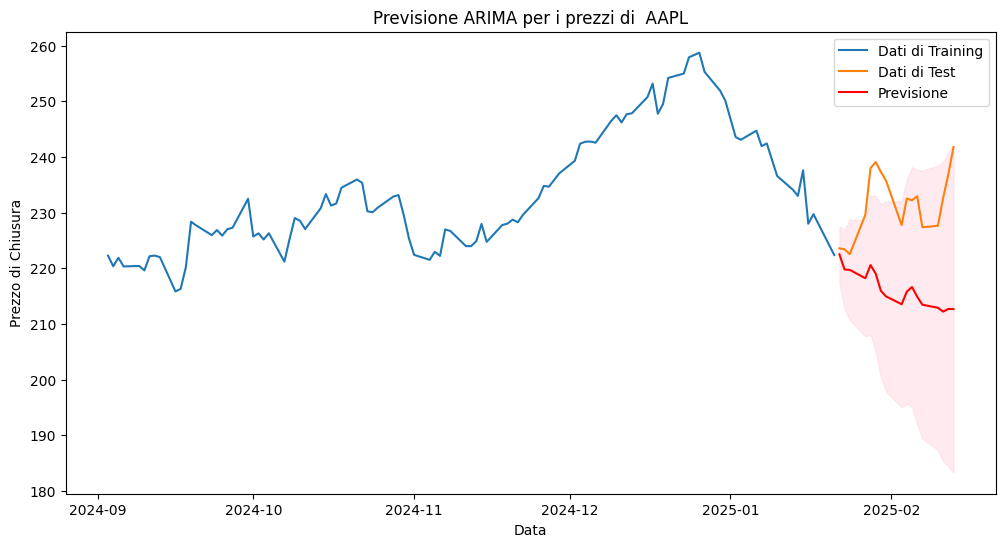

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings

warnings.filterwarnings("ignore")

# -----------------------------------------------------
# Scaricamento dei dati storici di AAPL
# -----------------------------------------------------
start_date = '2024-09-01'
# Se non viene specificato l'end_date, verranno presi i dati fino ad oggi
data = yf.download('AAPL', start=start_date)
close = data['Close'].dropna()

# -----------------------------------------------------
# Divisione del dataset: 70% per il training, 30% per il test
# -----------------------------------------------------
split_index = int(len(close) * 0.85)
train = close.iloc[:split_index]
test  = close.iloc[split_index:]

# Visualizziamo le prime righe dei dataset di training e test
print("Dimensione del dataset totale:", len(close))
print("Dimensione del training set:", len(train))
print("Dimensione del test set:", len(test))




# -----------------------------------------------------
# Differenziazione della serie di training
# -----------------------------------------------------
train_diff = train.diff().dropna()

# Test di stazionarietà (ADF) sulla serie differenziata di training
result_diff = adfuller(train_diff)
print('\nRisultati Test ADF sulla serie di training differenziata:')
print(f'ADF Statistic: {result_diff[0]:.4f}')
print(f'p-value: {result_diff[1]:.4f}')

# Plot di ACF e PACF della serie differenziata di training
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train_diff, lags=10, ax=axes[0])
axes[0].set_title('ACF della serie differenziata (training)')
plot_pacf(train_diff, lags=10, ax=axes[1])
axes[1].set_title('PACF della serie differenziata (training)')
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# Fit del modello ARIMA sui dati di training
# -----------------------------------------------------
# In questo esempio si utilizza un modello ARIMA(16, 1, 0)
order = (9,1,9)  # (p, d, q)
model = ARIMA(train, order=order)
model_fit = model.fit()

print("\nSintesi del modello ARIMA adattato sui dati di training:")
print(model_fit.summary())

# -----------------------------------------------------
# Diagnostica del modello sui residui (training)
# -----------------------------------------------------
residuals = model_fit.resid

plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residui del modello ARIMA (training)')
plt.subplot(212)
plt.hist(residuals, bins=30)
plt.title('Istogramma dei residui (training)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plot_acf(residuals, lags=10)
plt.title('ACF dei residui (training)')
plt.show()

# Test Ljung-Box per verificare l'assenza di autocorrelazione nei residui
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Risultati del Test Ljung-Box sui residui (training):")
print(lb_test)

# -----------------------------------------------------
# Previsione: utilizziamo il modello ARIMA per prevedere il periodo di test
# -----------------------------------------------------
forecast_steps = len(test)  # il numero di previsioni coincide con la dimensione del test set
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int()

# L'indice per le previsioni corrisponde a quello del test set
forecast_index = test.index

# -----------------------------------------------------
# Plot dei dati: training, test e previsioni con intervalli di confidenza
# -----------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(train, label='Dati di Training')
plt.plot(test, label='Dati di Test')
plt.plot(forecast_index, forecast_mean, label='Previsione', color='red')
plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('Previsione ARIMA per i prezzi di  AAPL')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura')
plt.legend()
plt.show()
